## MergeNet architecture

Multi-stage training with weight-sharing, learning separately the low and high-level features from RGBD input and fusing them in a refining stage.

Trained and evaluated on Lost and Found dataset.

Combining both appearance cues (RGB) and depth information performs better in identifying small obstacles and it is less sensitive to missinterpreting markings and zebra crossings as obstacles on the road (which could also cause a change in the image gradients) as obstacle edges.

MergeNet can be trained on small dataset (135 images) and still obtain promising results.

Contains 3 networks:
  - stripe-net: fully convolutional encoder-decoder trained with vertical strips of RGBD input
    - learns low-level features from vertical pathways of road images
    - shares parameters across stripes to reduce complexity and overfitting
  - context-net: also a fully convolutional encoder-decoder but trained on the whole image
    - learns high-level features from a wider region than a stripe-width
  - refiner-net: aggregate low- and high-level features and make the final prediction

The encoder & decoder blocks used for upsampling and downsampling the image is based on the Segnet network's architecture.
    - encoder: downsamples the input image through a series of convolutions, batch normalization and pooling layers
    - decoder: upsamples the encoded features through series of deconvolutions, batch normalization and unpooling layers until it re-obtains the original input resolution



In [110]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import os
import shutil
from packaging import version
import sklearn.metrics
import PIL.Image as Image
from keras.utils import to_categorical

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.10.1


In [2]:
# test if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
print(tf.config.experimental.get_device_details(physical_devices[0]))
logical_devices = tf.config.list_logical_devices('GPU')
print(logical_devices)
GPU_NAME = logical_devices[0].name
print("logical GPU name = ", GPU_NAME)

{'device_name': 'NVIDIA GeForce RTX 3060 Laptop GPU', 'compute_capability': (8, 6)}
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
logical GPU name =  /device:GPU:0


In [139]:
def conv_layer(input, size=64, kernel=2, activation_fct="relu"):
    conv = layers.Conv2D(size, kernel, padding="same", input_shape=input.shape[1:])(input)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation(activation_fct)(conv)
    return conv

def encoder_decoder(input_shape,
                    kernel=(3, 3),
                    pool_size=(2, 2)):
    inputs = layers.Input(shape=input_shape, dtype=float)
    inputs = layers.Rescaling(scale=1./255) (inputs)

    # encoder: 4 convolutional layers
    conv_1 = conv_layer(input=inputs, size=8, kernel=kernel, activation_fct="relu")
    pool_1 = layers.MaxPooling2D(pool_size)(conv_1)

    conv_2 = conv_layer(input=pool_1, size=16, kernel=kernel, activation_fct="relu")
    pool_2 = layers.MaxPooling2D(pool_size)(conv_2)

    conv_3 = conv_layer(input=pool_2, size=32, kernel=kernel, activation_fct="relu")
    pool_3 = layers.MaxPooling2D(pool_size)(conv_3)

    conv_4 = conv_layer(input=pool_3, size=64, kernel=kernel, activation_fct="relu")
    pool_4 = layers.MaxPooling2D(pool_size)(conv_4)

    # decoder: 4 convolutional layers
    unpool_1 = layers.UpSampling2D(pool_size)(pool_4)
    conv_5 = conv_layer(input=unpool_1, size=64, kernel=kernel, activation_fct="relu")

    unpool_2 = layers.UpSampling2D(pool_size)(conv_5)
    conv_6 = conv_layer(input=unpool_2, size=32, kernel=kernel, activation_fct="relu")

    unpool_3 = layers.UpSampling2D(pool_size)(conv_6)
    conv_7 = conv_layer(input=unpool_3, size=16, kernel=kernel, activation_fct="relu")

    unpool_4 = layers.UpSampling2D(pool_size)(conv_7)
    conv_8 = conv_layer(input=unpool_4, size=8, kernel=kernel, activation_fct="relu")

    model = keras.Model(inputs=inputs, outputs=conv_8)
    return model

def stripe_net(rgb_input_shape, depth_input_shape, nr_labels):
    rgb_enc_dec = encoder_decoder(input_shape=rgb_input_shape, kernel=(3, 3), pool_size=(2, 2))
    depth_enc_dec = encoder_decoder(input_shape=depth_input_shape, kernel=(3, 3), pool_size=(2, 2))
    concatenated = layers.Concatenate(axis=1)([rgb_enc_dec.output, depth_enc_dec.output])
    conv = conv_layer(input=concatenated, size=nr_labels, kernel=(1,1), activation_fct="relu")
    outputs = layers.Activation(activation="softmax")(conv)
    model = keras.Model(inputs=[rgb_enc_dec.input, depth_enc_dec.input], outputs=outputs, name='stripe-net')
    return model

In [4]:
[train_ds, valid_ds, test_ds], info = tfds.load(name="lost_and_found/full", split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], with_info=True)

In [6]:
train_ds.element_spec

{'disparity_map': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None),
 'image_id': TensorSpec(shape=(), dtype=tf.string, name=None),
 'image_left': TensorSpec(shape=(1024, 2048, 3), dtype=tf.uint8, name=None),
 'image_right': TensorSpec(shape=(1024, 2048, 3), dtype=tf.uint8, name=None),
 'instance_id': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None),
 'segmentation_label': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None)}

In [7]:
print("Nr training instances = ", train_ds.cardinality().numpy())
print("Nr validation instances = ", valid_ds.cardinality().numpy())
print("Nr test instances = ", test_ds.cardinality().numpy())

Nr training instances =  829
Nr validation instances =  103
Nr test instances =  104


In [22]:
def preprocess_input(dataset):
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=10)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [23]:
BATCH_SIZE = 4
NUM_CLASSES = 44
IMG_HEIGHT = 1024
IMG_WIDTH = 2048
k = 32

train_input = preprocess_input(train_ds)
valid_input = preprocess_input(valid_ds)
test_input = preprocess_input(test_ds)

(array([1789804,  306668,     680], dtype=int64), array([0, 1, 6, 7], dtype=uint8))


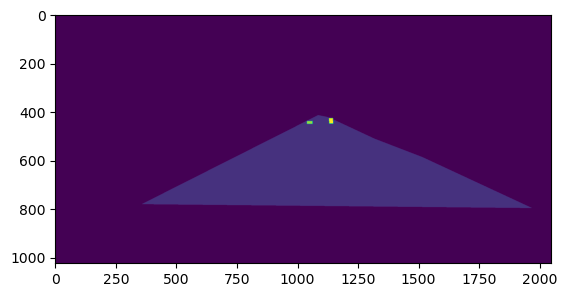

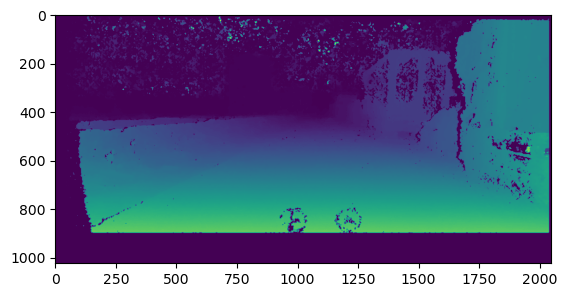

In [10]:
for data in train_input:
    print(np.histogram(data['segmentation_label'].numpy()[0], bins=np.unique(data['segmentation_label'].numpy()[0])))
    plt.figure()
    plt.imshow(data['segmentation_label'].numpy()[0])
    plt.figure()
    plt.imshow(data['disparity_map'].numpy()[0])
    break

In [16]:
def encode_labels(mask):
    original_shape = mask.shape
    mask = tf.reshape(mask, (-1, 1))
    mask = tf.map_fn(fn=lambda x: x if x < 2 else x-(x-2), elems=mask)
    mask = tf.reshape(mask, original_shape)
    return mask
# train_labels = train_input.map(lambda x: tf.map_fn(lambda y: encode_labels(y),x['segmentation_label']))

In [79]:
# create stripes of size k and fixed width
def create_stripes(x, y, k):
    x = tf.split(x, num_or_size_splits=k, axis=1)
    y = tf.split(y, num_or_size_splits=k, axis=1)
    return x, y

train_rgb_input = train_ds.map(lambda x: (x['image_left'], x['segmentation_label']))
train_rgb_input = train_rgb_input.flat_map(lambda x, y : tf.data.Dataset.from_tensor_slices(create_stripes(x, y, k)))
train_rgb_input = preprocess_input(train_rgb_input)
print(train_rgb_input.element_spec)

train_depth_input = train_ds.map(lambda x: (x['disparity_map'], x['segmentation_label']))
train_depth_input = train_depth_input.flat_map(lambda x, y : tf.data.Dataset.from_tensor_slices(create_stripes(x, y, k)))
train_depth_input = preprocess_input(train_depth_input)
print(train_depth_input.element_spec)

(TensorSpec(shape=(1024, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1024, 64, 1), dtype=tf.uint8, name=None))
(TensorSpec(shape=(1024, 64, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(1024, 64, 1), dtype=tf.uint8, name=None))


In [140]:
stripe_net_model = stripe_net(rgb_input_shape=(IMG_HEIGHT, IMG_WIDTH//k, 3),
                              depth_input_shape=(IMG_HEIGHT, IMG_WIDTH//k, 1),
                              nr_labels=NUM_CLASSES)
print(stripe_net_model.summary())

Model: "stripe-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 1024, 64, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_49 (InputLayer)          [(None, 1024, 64, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_176 (Conv2D)            (None, 1024, 64, 8)  224         ['input_47[0][0]']               
                                                                                         